### <div align="center">***CLASIFICACION DE CITOLOGIAS***</div>
***
Clasificador de imágenes de citologías cervicovaginales al microscopio óptico (supervisado)


##### **IMPORTACION DE LIBRERIAS** 

In [156]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
from skimage.io import imread
import cv2
import traceback

##### **CONSTANTES** 

In [138]:
# DIMENSIONES DE LAS IMAGENES DE CITOLOGIAS AL MICROSCOPIO

ANCHURA_IMAGEN = 700
ALTURA_IMAGEN =700
CHANNELS_IMAGEN = 1 # RGB o color(3) - GRISES (1)
IMAGE_SIZE = (ANCHURA_IMAGEN, ALTURA_IMAGEN, CHANNELS_IMAGEN)
BATCH_SIZE = 10
EPOCHS = 5
TRAIN_PATH = "../MLproject/" # Ruta de los archivos

##### **TRAINING**

In [69]:
# CREAMOS UN DATAFRAME CON LOS ARCHIVOS DE LAS IMAGENES

lista_archivos = os.listdir(TRAIN_PATH) # Lista de los archivos de imagen en el directorio especificado
df = pd.DataFrame()
categoria = [0 if 'normal' in file else 1 for file in lista_archivos] 
df['nombre_archivo'] = lista_archivos # Columna con los nombres de los archivos de imagen
df['categoria'] = categoria # Columna con la categoría de los arhcivos: 0 citologia normal - 1 citologia cancerosa
df

,nombre_archivo,categoria
0,cancer.ASC1.png,1
1,cancer.ASC2.jpg,1
2,cancer.ASC3.png,1
3,cancer.ASC4.png,1
4,cancer.ASC5.png,1
5,cancer.HSIL1.jpg,1
6,cancer.HSIL2.png,1
7,cancer.HSIL3.jpg,1
8,cancer.HSIL4.png,1
9,cancer.HSIL5.jpg,1


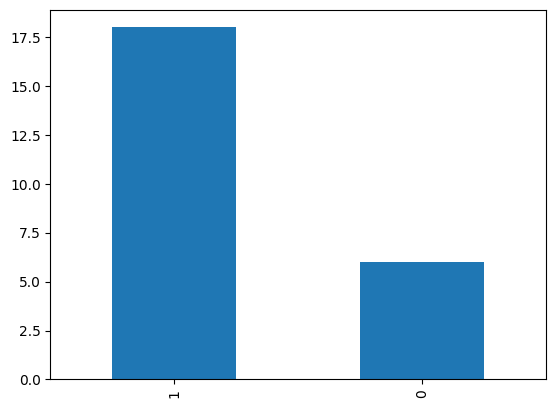

In [70]:
df['categoria'].value_counts().plot.bar(); # Comprobamos que el número de muestras es equitativo

Tamaño imagen original: (1920, 2560, 3)
Tamaño imagen reshape: (700, 700, 3)
Maximo valor por pixel: 255


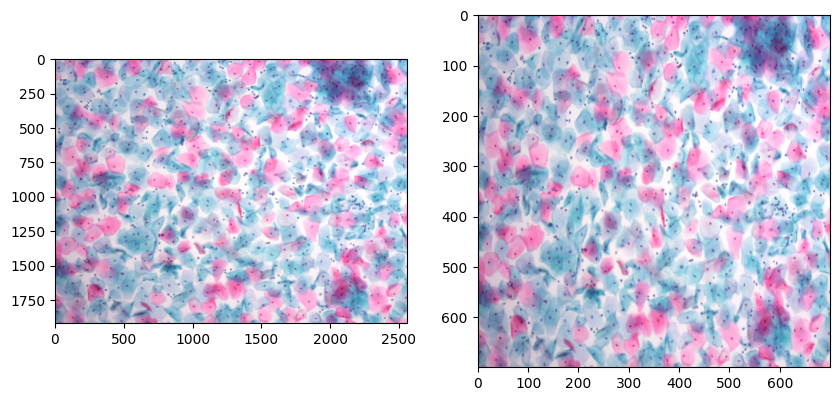

In [76]:
# RESIZE IMAGE (ajustamos las imagenes a la misma resolucion)

plt.figure(figsize=(10, 10))

archivo = random.choice(lista_archivos)
image = imread(TRAIN_PATH + "/" + archivo)
image_resized = cv2.resize(image, (ANCHURA_IMAGEN, ALTURA_IMAGEN))

print("Tamaño imagen original:", image.shape)
print("Tamaño imagen reshape:", image_resized.shape)
print("Maximo valor por pixel:", np.max(image_resized))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(image)

# Resized image
plt.subplot(1, 2, 2)
plt.imshow(image_resized);

Dimensiones: (527, 813)
Maximo color: 255


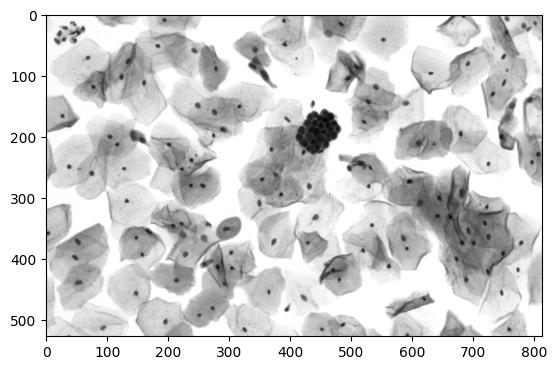

In [78]:
# CAMBIAMOS LA ESCALA A BLANCO Y NEGRO

archivo = random.choice(lista_archivos)

image = cv2.imread(filename=TRAIN_PATH + archivo, flags=cv2.IMREAD_GRAYSCALE) 

print("Dimensiones:", image.shape)
print("Maximo color:", np.max(image))
plt.imshow(image,cmap='gray'); # Muestra la imagen en escala de grises

##### **LOAD DATA**

In [139]:
# FUNCION PARA LEER DATOS ITERATIVAMENTE

def read_data(path, img_size, num_imagenes):
    X = []
    Y = []
    
    lista_imagenes = np.random.choice(os.listdir(path), size = num_imagenes) # Genera una lista de imagenes contenidas en el directorio
    
    for imagen in lista_imagenes:
            imagen_gris = imread(path + imagen, True) # Seteamos con 'True' la lectura en escala de grises (1D)
            imagen_resized = cv2.resize(imagen_gris, (ANCHURA_IMAGEN, ALTURA_IMAGEN)) # Cambiamos resolución de la imagen

            X.append(imagen_resized)

            if 'normal' in imagen:
                Y.append(0)
            else:
                Y.append(1)


    return np.array(X), np.array(Y)

In [140]:
X,Y = read_data(TRAIN_PATH, IMAGE_SIZE, 24) # Leemos los datos

In [142]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,Y,random_state=10,test_size=5,stratify=Y)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(19, 700, 700)
(5, 700, 700)
(19,)
(5,)


##### **NORMALIZACION**

In [149]:
print('Min:',np.min(X_train))
print('Max:',np.max(X_train))

Min: 0.01676488464985987
Max: 1.0


In [150]:
X_train = X_train/255.0
X_test = X_test/255.0

print('Min:',np.min(X_train))
print('Max:',np.max(X_train))

Min: 6.574464568572499e-05
Max: 0.00392156862745098


##### **MEZCLA DATOS**

In [151]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=42)

##### **GUARDAR/CARGAR DATOS**

In [152]:

np.savez('data.npz', X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

In [153]:
data = np.load('data.npz')

X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']

##### **MODELO**

In [154]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation

model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu',
                input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1,activation='sigmoid'))

'''
También podríamos haber usado dos neuronas de salida.
Para ello hay que pasar la "y" a one-hot-encoding usando 

from keras.utils import to_categorical
y_train = to_categorical(y_train)

La capa de salida sería:
model.add(Dense(2, activation='softmax'))

Si tuviera 3 o más clases tendría que usar esta opción
'''

model.compile(optimizer='adam', loss='binary_crossentropy',
             metrics=['accuracy'])

##### **FIT**

In [ ]:
history = model.fit(X_train,y_train,epochs=10,
                   batch_size=BATCH_SIZE,
                   validation_split=0.2)

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.show()